In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

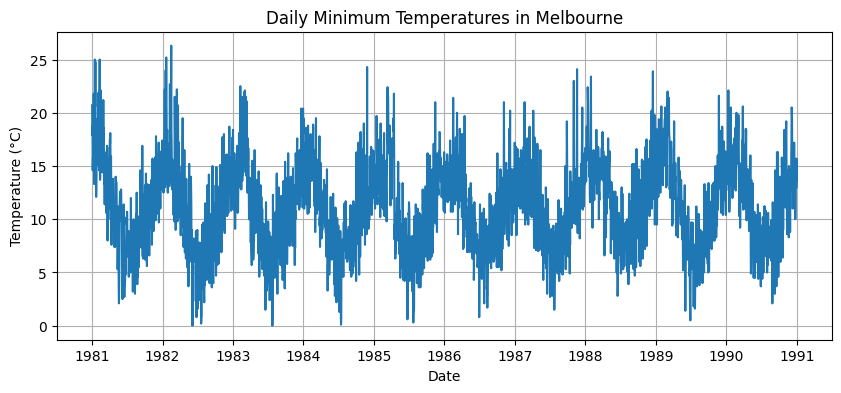

        Date  Value
0 1981-01-01   20.7
1 1981-01-02   17.9
2 1981-01-03   18.8
3 1981-01-04   14.6
4 1981-01-05   15.8


In [3]:
# Load dataset from URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url, parse_dates=['Date'])

# Rename column
data = data.rename(columns={'Temp': 'Value'})

# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(data['Date'], data['Value'])
plt.title("Daily Minimum Temperatures in Melbourne")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

# Show head
print(data.head())

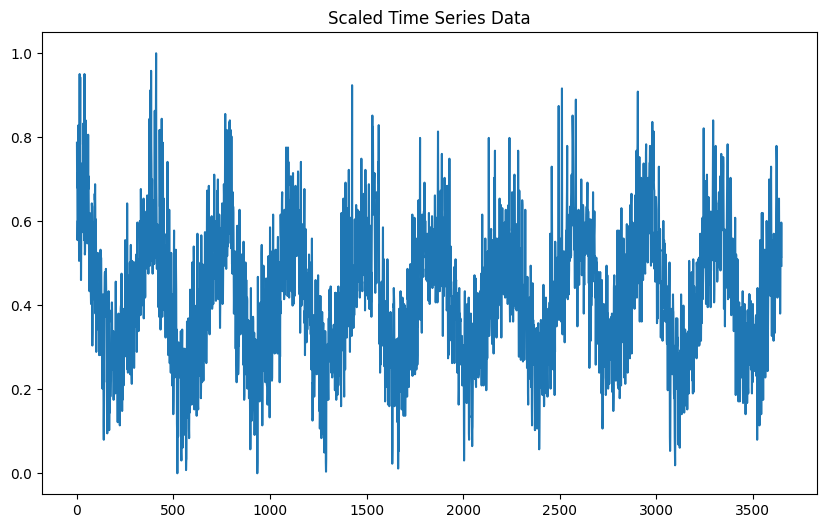

In [4]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Value'].values.reshape(-1, 1))

# Visualize the scaled data
plt.figure(figsize=(10, 6))
plt.plot(scaled_data)
plt.title('Scaled Time Series Data')
plt.show()

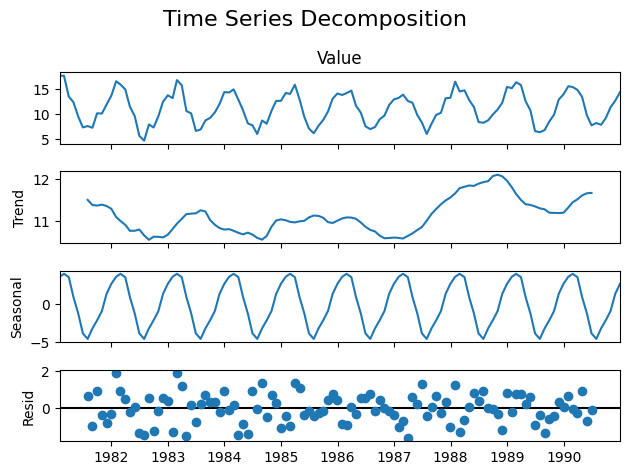

In [9]:
import statsmodels.api as sm

# Set 'Date' as the index
data = data.set_index('Date')

# Use 'Value' to access the temperature data and resample to monthly frequency
data_monthly = data['Value'].resample('ME').mean()  # Changed 'M' to 'ME'
data_monthly = data_monthly.to_frame(name='Value')
decomposition = sm.tsa.seasonal_decompose(data_monthly['Value'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
import numpy as np

# Function to create supervised learning dataset from time series
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Example usage
time_step = 60  # Number of past time steps to use

# Create supervised dataset
X, y = create_dataset(scaled_data, time_step)

# Reshape X to 3D [samples, time steps, features] as required by LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [13]:
# Train-test split (80% training, 20% testing)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001, time_steps=60):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [17]:
model = build_lstm_model(time_steps=X_train.shape[1])
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0558 - val_loss: 0.0102
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0136 - val_loss: 0.0106
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0131 - val_loss: 0.0102
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0127 - val_loss: 0.0102
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0129 - val_loss: 0.0095
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0138 - val_loss: 0.0095
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0124 - val_loss: 0.0091
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0126 - val_loss: 0.0107
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0121 - val_loss: 0.0089
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0120 - val_loss: 0.0089


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


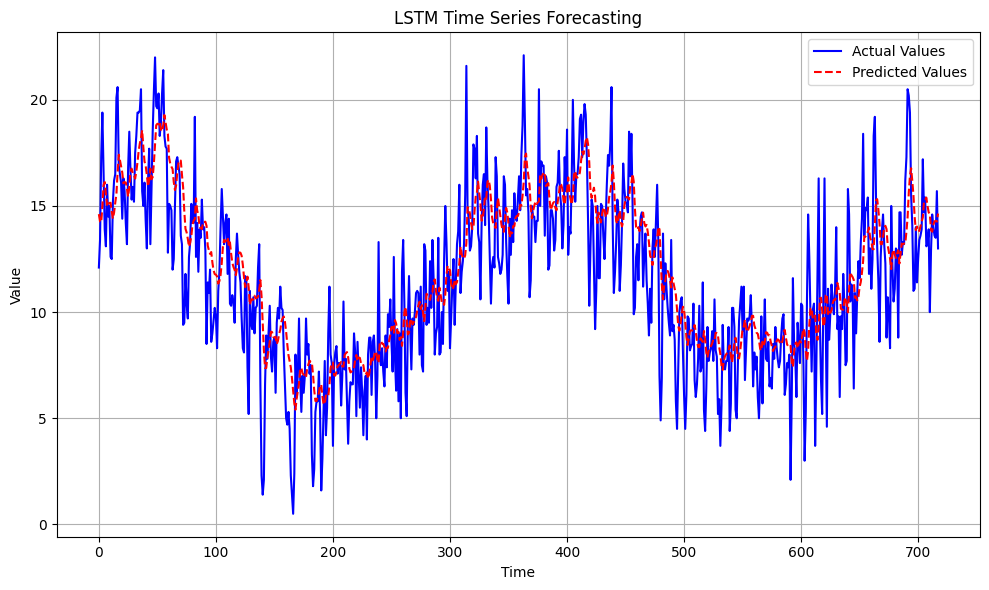

In [18]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual Values', color='blue')
plt.plot(y_pred_inverse, label='Predicted Values', color='red', linestyle='dashed')
plt.title('LSTM Time Series Forecasting')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Squared Error (MSE): 6.180
Mean Absolute Error (MAE): 1.919
Root Mean Squared Error (RMSE): 2.486
